In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

i_plot = False

In [2]:
import os
cal_img_list = os.listdir("camera_cal/")
test_img_list = os.listdir("test_images/")

[[1.15662906e+03 0.00000000e+00 6.69041437e+02]
 [0.00000000e+00 1.15169194e+03 3.88137240e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-0.2315715  -0.12000537 -0.00118338  0.00023305  0.15641571]]
[[1.15662906e+03 0.00000000e+00 6.69041437e+02]
 [0.00000000e+00 1.15169194e+03 3.88137240e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[-0.2315715  -0.12000537 -0.00118338  0.00023305  0.15641571]]


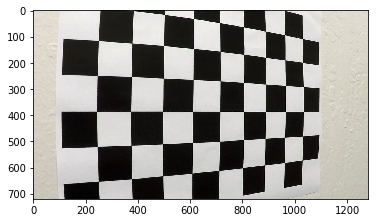

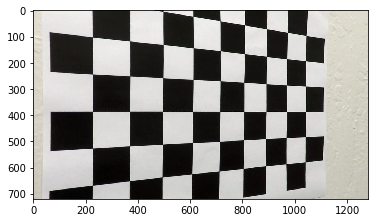

In [3]:
def calibrate_camera():

    nx = 9
    ny = 6

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    for image_file in cal_img_list:
        img  = mpimg.imread('camera_cal/' + image_file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Do camera calibration given object points and image points
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    if 1:
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        print(mtx)
        print(dist)
        for image_file in cal_img_list:
            img = mpimg.imread('camera_cal/' + image_file)
            dst = cv2.undistort(img, mtx, dist, None, mtx)
            plt.figure()
            plt.imshow(img)
            plt.draw()
            fig = plt.figure()
            plt.imshow(dst)
            plt.draw()
            fig.savefig('output_images/calibrate.png')
            break
    
    return [mtx, dist]

[mtx, dist] = calibrate_camera()
print(mtx, dist)

if 0:
    for img_file in test_img_list:
        img  = mpimg.imread('test_images/' + img_file)
        dst = cv2.undistort(img, mtx, dist, None, mtx)

        plt.figure()
        plt.imshow(img)
        plt.draw()
        plt.figure()
        plt.imshow(dst)
        plt.draw()
        break

In [4]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
#     plt.figure()
#     plt.imshow(mask)
#     plt.draw()    
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [5]:
# Use color transforms, gradients, etc., to create a thresholded binary image.
# def create_binary_image(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
def create_binary_image(img, s_thresh=(90, 255), sx_thresh=(20, 100), h_thresh=(5, 55)):
    img = np.copy(img)
    # Convert to HLS color space and select the channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Restrict relevant hues for saturation thresholding to filter out shadows
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Compute the X gradient on the l channel
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel using the hue binary to mask shadows from the saturation binary
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary & h_binary)) * 255
    
    # Mask region of interest
    ysize = color_binary.shape[0]
    xsize = color_binary.shape[1]
    vertices = np.array([[[0, ysize], [0.438*xsize, 0.627*ysize], [(1-0.438)*xsize, 0.627*ysize], [xsize, ysize]]], dtype=np.int32)
    
    #returning the image only where mask pixels are nonzero
    masked_color_binary = region_of_interest(color_binary, vertices)
    
    return masked_color_binary

# for img_file in test_img_list:
#     img  = mpimg.imread('test_images/' + img_file)
#     break

# binary_img = create_binary_image(img)
# plt.figure()
# plt.imshow(img)
# plt.draw()
# plt.figure()
# plt.imshow(binary_img)
# plt.draw()
# plt.figure()
# plt.imshow(masked_binary_img)
# plt.draw()


In [6]:
# * Apply a perspective transform to rectify binary image ("birds-eye view").
def compute_perspective_transform_matrix(img):
    width = img.shape[1]
    height = img.shape[0]

    xfactor1 = 0
    xfactor2 = 0.447
    xfactor3 = 0.3
    yfactor = 0.627
    # Source pointe hand-picked from lane image
    src = np.float32([[xfactor2*width, yfactor*height], 
                      [(1-xfactor2)*width, yfactor*height], 
                      [(1-xfactor1)*width, height],
                      [xfactor1*width, height]])
    # Destination pointe hand-picked from assumed bird's eye view
    dst = np.float32([[xfactor3*width, 0], 
                      [(1-xfactor3)*width, 0], 
                      [(1-xfactor3)*width, height],
                      [xfactor3*width, height]])
    # Compute the tranform matrix
    return cv2.getPerspectiveTransform(src, dst)

for img_file in test_img_list:
    img  = mpimg.imread('test_images/' + img_file)
    perspective_matrix = compute_perspective_transform_matrix(img)
    break


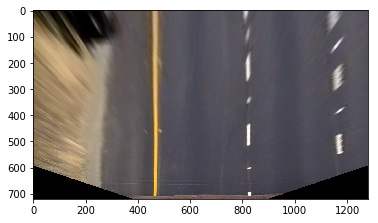

In [7]:
def create_birds_eye_view(img, perspective_matrix):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, perspective_matrix, img_size)

if 1:
    for img_file in test_img_list:
    #     img  = mpimg.imread('test_images/' + img_file)
        img  = mpimg.imread('test_images/' + 'straight_lines1.jpg')
        birds_eye_view = create_birds_eye_view(img, perspective_matrix)

        fig = plt.figure()
        plt.imshow(birds_eye_view)
        plt.draw()
        fig.savefig('output_images/birds_eye.png')

        break

In [8]:
# Bootstrap lane finding method when no prior polynomial fits exist
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
#         # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# Lane finding method when previous polynomial exists
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, ym_per_pix, xm_per_pix, left_fit_prev, right_fit_prev):
    global i_plot
    
    # Find our lane pixels first
    if left_fit_prev == [] or right_fit_prev == []:
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    else:
        leftx, lefty, rightx, righty, out_img = search_around_poly(binary_warped, left_fit_prev, right_fit_prev)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    if i_plot:
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        fig = plt.figure()
        plt.imshow(out_img)
        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.draw()
        fig.savefig('output_images/polyfit.png')
    
    return left_fit_cr, right_fit_cr, left_fit, right_fit, left_fitx, right_fitx, ploty

In [9]:
def measure_curvature_real(binary_warped, left_fit_cr, right_fit_cr, ym_per_pix, xm_per_pix):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = binary_warped.shape[0]*ym_per_pix
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate lateral position
    left_pos = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    right_pos = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]    
    image_width_in_pixels = binary_warped.shape[1]
    lateral_pos = 0.5 * (left_pos + right_pos) - 0.5*image_width_in_pixels*xm_per_pix
    
    # Noise tends to reduce curvature so assume that lower curve radius estimate is more accurate
    if (abs(left_curverad) < abs(right_curverad)):
        curverad = left_curverad
    else:
        curverad = right_curverad
    
    return curverad, lateral_pos


In [10]:
def low_pass_filter(x, x_prev, factor):
    if x_prev == []:
        x_filt = x
    else:
        x_filt = factor*x + (1-factor)*x_prev
    return x_filt

In [11]:
def display_result(undistorted_image, birds_eye, left_fitx, right_fitx, ploty, perspective_matrix, curverad, lateral_pos):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(birds_eye).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.inv(perspective_matrix)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    txt1 = "Radius of curvature = %0.1f m" % curverad
    if lateral_pos > 0:
        txt2 = "Vehicle is %0.3f m left of road center" % abs(lateral_pos)
    else:
        txt2 = "Vehicle is %0.3f m right of road center" % abs(lateral_pos)
    cv2.putText(result, txt1, (50, 50), font, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, txt2, (50, 100), font, 1.2, (255, 255, 255),2 , cv2.LINE_AA)
    
    return result

In [12]:
left_fit_prev = []
right_fit_prev = []

curverad_prev = []
lateral_pos_prev = []

def process_image(img):

    global mtx, dist, perspective_matrix, left_fit_prev, right_fit_prev, curverad_prev, lateral_pos_prev, i_plot
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Apply distortion correction
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)

    # Create binary image that is color coded to show detection method
    color_binary_image = create_binary_image(undistorted_image)
    
    # Convert to monochrome binary image
    gray = cv2.cvtColor(color_binary_image, cv2.COLOR_RGB2GRAY)
    binary_image = np.zeros_like(gray)
    binary_image[gray > 5] = 1
    
    # Create birds-eye view
    birds_eye = create_birds_eye_view(binary_image, perspective_matrix)

    # Compute lane boundaries
    left_fit_cr, right_fit_cr, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(birds_eye, ym_per_pix, xm_per_pix, left_fit_prev, right_fit_prev)

    # Record previous fit for faster find
    left_fit_prev = left_fit
    right_fit_prev = right_fit
    
    # Compute lane curvature and vehicle position
    curverad, lateral_pos = measure_curvature_real(birds_eye, left_fit_cr, right_fit_cr, ym_per_pix, xm_per_pix)
    
    # Low-pass filter curvature and position
    curverad_filt    = low_pass_filter(curverad, curverad_prev, 0.05)
    lateral_pos_filt = low_pass_filter(lateral_pos, lateral_pos_prev, 0.1)
    curverad_prev    = curverad_filt
    lateral_pos_prev = lateral_pos_filt
    
    # Display result
    result = display_result(undistorted_image, birds_eye, left_fitx, right_fitx, ploty, perspective_matrix, curverad_filt, lateral_pos_filt)
    
    if i_plot:
        fig = plt.figure()
        plt.imshow(undistorted_image)
        plt.draw()
        fig.savefig('output_images/undistort.png')
        fig = plt.figure()
        plt.imshow(binary_image)
        plt.draw()
        fig.savefig('output_images/binary_image.png')
        plt.figure()
        plt.imshow(birds_eye)
        plt.draw()
        fig = plt.figure()
        plt.imshow(result)
        plt.draw()
        fig.savefig('output_images/result.png')        

    return result

if i_plot:
    for img_file in test_img_list:
    #     img  = mpimg.imread('test_images/' + img_file)
        img  = mpimg.imread('test_images/' + 'test2.jpg')
        process_image(img)
        break

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
project_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:36<00:00, 13.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 4s, sys: 32 s, total: 6min 36s
Wall time: 1min 37s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [16]:
challenge_output = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip("challenge_video.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [00:46<00:00, 11.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 2min 48s, sys: 14.5 s, total: 3min 3s
Wall time: 47.2 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))